In [1]:
from PIL import *
import numpy as np
import cv2
from cv2 import *
from scipy.ndimage import *
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.hub
import os
from torchvision.datasets import *
import random
import torch.utils.data as Data


In [2]:
DATA_ROOT = r'D:\onedrive\eyisheng\OneDrive\files\大三下\科研\金属分类\data'
DATA_ROOT_CORROSION = DATA_ROOT + r'\corrosion'
DATA_ROOT_NONCORROSION = DATA_ROOT + r'\noncorrosion'

DATASET_ROOT = './dataset'
DATASET_ROOT_TRAIN = os.path.join(DATASET_ROOT,'train')
DATASET_ROOT_TEST = os.path.join(DATASET_ROOT,'test')
DATASET_TRAIN_POS = os.path.join(DATASET_ROOT_TRAIN,'1')
DATASET_TRAIN_NEG = os.path.join(DATASET_ROOT_TRAIN,'0')
DATASET_TEST_POS = os.path.join(DATASET_ROOT_TEST,'1')
DATASET_TEST_NEG = os.path.join(DATASET_ROOT_TEST,'0')

if not os.path.exists(DATASET_ROOT_TRAIN):
    os.mkdir(DATASET_ROOT_TRAIN)

if not os.path.exists(DATASET_ROOT_TEST):
    os.mkdir(DATASET_ROOT_TEST)

In [ ]:
#### get raw jpg files from directories
def getFileNames(is_corrosion=False):
    path_files = []
    walk_root = DATA_ROOT_NONCORROSION if is_corrosion==False else DATA_ROOT_CORROSION
    
    for root, dirs, files in os.walk(walk_root):
        for f in files:
            fpath = os.path.join(root,f)
            path_files.append(fpath)
            
    label = 0 if is_corrosion==False else 1
    res = list(map(lambda x:(x,label),path_files))
    return res


def checkImgShape():
    shapes = set()
    for line in non_corrosion_files:
        jpgfile = Image.open(line[0])
        jpgfile = np.array(jpgfile)
        shapes.add(jpgfile.shape)
    return shapes


def resizeImg(src,dsize):
    jpgfile = Image.open(src)
    jpgfile = np.array(jpgfile)
    jpgfile = cv2.resize(jpgfile,dsize)
    return jpgfile


def preprocessingPipeline(src,target):
    img = resizeImg(src,(256,256)) ### image shapes
    return [src,target,img]
    
    
def filesToImg(path_files):
    train = []
    test = []
    for line in path_files:
        if random.random()<0: ### train test split
            test.append( preprocessingPipeline(line[0],line[1]) )
        else:
            train.append( preprocessingPipeline(line[0],line[1]) )
    return {'train':train,'test':test}
    
    
def saveImgToFiles(imgs):
    
    if not os.path.exists(DATASET_TRAIN_POS):
        os.mkdir(DATASET_TRAIN_POS)
    if not os.path.exists(DATASET_TRAIN_NEG):
        os.mkdir(DATASET_TRAIN_NEG) 
    if not os.path.exists(DATASET_TEST_POS):
        os.mkdir(DATASET_TEST_POS)
    if not os.path.exists(DATASET_TEST_NEG):
        os.mkdir(DATASET_TEST_NEG)
        
    for line in imgs['train']:
        src = os.path.split(line[0])[-1]
        if line[1]==0:
            src = os.path.join(DATASET_TRAIN_NEG,src)
        elif line[1]==1:
            src = os.path.join(DATASET_TRAIN_POS,src)
        Image.fromarray(line[2]).save(src)
        
    for line in imgs['test']:
        src = os.path.split(line[0])[-1]
        if line[1]==0:
            src = os.path.join(DATASET_TEST_NEG,src)
        elif line[1]==1:
            src = os.path.join(DATASET_TEST_POS,src)
        Image.fromarray(line[2]).save(src)
    return

In [ ]:
def ImgWriter():
    img_data = filesToImg(img_files)

    saveImgToFiles(img_data)
    return


# non_corrosion_files = getFileNames(is_corrosion=False)
# corrosion_files = getFileNames(is_corrosion=True)
# img_files = corrosion_files
# img_files.extend(non_corrosion_files)
# del corrosion_files,non_corrosion_files
# ImgWriter()

In [6]:
EPOCH = 20
BATCH_SIZE = 6
NUM_CLASS = 2
CV = 5

P_momentem = 0.8
P_lr = 1e-3
train_ratio = 0.8 

In [7]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5, 0.5, 0.5])
])

full_dataset = ImageFolder(DATASET_ROOT_TRAIN,transform = data_transform)

total_size = len(full_dataset)
train_size = int(np.floor( total_size * train_ratio ))
test_size = int(total_size - train_size)


In [6]:
hub_model = torch.hub.load(
    'moskomule/senet.pytorch',
    'se_resnet20',
    num_classes=NUM_CLASS,
#     pre_trained=True
)
net = hub_model

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=P_lr)

Using cache found in C:\Users\steve/.cache\torch\hub\moskomule_senet.pytorch_master


In [8]:
_total_loss = []
_total_acc = []

for cv in range(CV):
    
    hub_model = torch.hub.load(
        'moskomule/senet.pytorch',
        'se_resnet20',
        num_classes=NUM_CLASS,
    #     pre_trained=True
    )
    net = hub_model

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=P_lr)
    
    dataset_train, dataset_test = torch.utils.data.random_split(full_dataset, [train_size,test_size])
    trainloader = Data.DataLoader(dataset=dataset_train, batch_size=BATCH_SIZE, shuffle=True)
    testloader = Data.DataLoader(dataset=dataset_test, batch_size=BATCH_SIZE, shuffle=True)
    _loss = []
    for epoch in range(EPOCH):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # print statistics
            running_loss += loss.item()
            _loss.append(running_loss)
            if i % 5 == 4:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, np.sum(_loss)/len(_loss)))
    print('Finished Training')

    
    class_correct = list(0. for i in range(NUM_CLASS))
    class_total = list(0. for i in range(NUM_CLASS))
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            if c.ndim==0:
                label = labels[0]
                class_correct[label] += c.item()
                class_total[label] += 1
                continue
            for i in range(np.min([BATCH_SIZE,len(labels)])):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    _acc = []
    for i in range(NUM_CLASS):
        print('Accuracy of  %f ' % ( 100 * class_correct[i] / class_total[i] ))
        _acc.append(100 * class_correct[i] / class_total[i])
    
    
    _total_loss.append(_loss)
    _total_acc.append(_acc)

[1,     5] loss: 1.584
[1,    10] loss: 2.193
[1,    15] loss: 2.707
[2,     5] loss: 2.320
[2,    10] loss: 2.032
[2,    15] loss: 1.876
[3,     5] loss: 1.731
[3,    10] loss: 1.590
[3,    15] loss: 1.507
[4,     5] loss: 1.382
[4,    10] loss: 1.325
[4,    15] loss: 1.351
[5,     5] loss: 1.323
[5,    10] loss: 1.314
[5,    15] loss: 1.327
[6,     5] loss: 1.264
[6,    10] loss: 1.212
[6,    15] loss: 1.180
[7,     5] loss: 1.236
[7,    10] loss: 1.291
[7,    15] loss: 1.358
[8,     5] loss: 1.341
[8,    10] loss: 1.305
[8,    15] loss: 1.281
[9,     5] loss: 1.235
[9,    10] loss: 1.201
[9,    15] loss: 1.176
[10,     5] loss: 1.133
[10,    10] loss: 1.103
[10,    15] loss: 1.078
[11,     5] loss: 1.059
[11,    10] loss: 1.047
[11,    15] loss: 1.038
[12,     5] loss: 1.021
[12,    10] loss: 1.004
[12,    15] loss: 0.995
[13,     5] loss: 0.970
[13,    10] loss: 0.949
[13,    15] loss: 0.932
[14,     5] loss: 0.907
[14,    10] loss: 0.890
[14,    15] loss: 0.878
[15,     5] loss: 0

KeyboardInterrupt: 

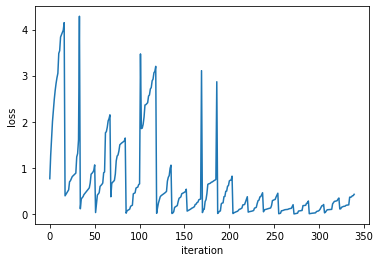

In [9]:
plt.figure()
plt.xlabel('iteration')
plt.ylabel('loss')
plt.plot(_total_loss)